<b> EBCM (Energy-Balance Climate Model) </b><br>
Reference: Walter A. Robinson, Modeling Dynamic Climate Systems

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-dark')

In [2]:
def EBCM(solar_const):
    # Mixing coefficient for Saturation humidity
    mixing_coef_for_q = mixing_velocity * p0/g * np.pi * earth_radius * lv * seconds_per_year/earth_area
    
    # Mixing coefficient for temperature
    mixing_coef_for_t = mixing_velocity * p0/g * np.pi * earth_radius * spec_heat_atm * seconds_per_year/earth_area

    # Incoming solar radiation of temperate and tropical latitudes
    s0_temperate = solar_const * temperate_coeff * seconds_per_year * (1 - albedo_temperate)
    s0_tropics = solar_const * tropics_coeff * seconds_per_year * (1 - albedo_tropics)

    # Initialize temperatures of temperate and tropical latitudes
    t_temperate = np.zeros((n,))
    t_tropics = np.zeros((n,))
    t_temperate[0] = 288
    t_tropics[0] = 288

    # Saturation humidity of temperate and tropical latitudes
    q_temperate = np.zeros((n, ))
    q_tropics = np.zeros((n, ))
    q_temperate[0] = rh * 0.0038 * np.exp(5423 * (1/273.15 - 1/t_temperate[0]))
    q_tropics[0] = rh * 0.0038 * np.exp(5423 * (1/273.15 - 1/t_tropics[0]))

    # Sensible heat
    sensible_heat = np.zeros((n, ))
    sensible_heat[0] = mixing_coef_for_t *  (t_tropics[0] - t_temperate[0])

    # Latent heat
    latent_heat = np.zeros((n, ))
    latent_heat[0] = mixing_coef_for_q * (q_tropics[0] - q_temperate[0])

    # IR of temperate and tropical latitudes
    ir_temperate = np.zeros((n, ))
    ir_tropics = np.zeros((n, ))
    ir_temperate[0] = (a * t_temperate[0] + b) * seconds_per_year
    ir_tropics[0] = (a * t_tropics[0]  + b) * seconds_per_year

    # Tropical-extratropical temperature contrast
    delta_t = np.zeros((n, ))
    
    # Mean global temperature
    t_globe = np.zeros((n, ))
    
    for k in range(1, n):
        # Temperatures of temperate and tropics latitudes
        t_temperate[k] = t_temperate[k-1] + ((sensible_heat[k-1] + latent_heat[k-1] + s0_temperate - ir_temperate[k-1]) * dt)/heat_capacity
        t_tropics[k] = t_tropics[k-1] + ((s0_tropics - sensible_heat[k-1] - latent_heat[k-1] - ir_tropics[k-1]) * dt)/heat_capacity
        
        # Saturation humidity of temperate and tropical latitudes
        q_temperate[k] = rh * 0.0038 * np.exp(5423 * (1/273 - 1/t_temperate[k]))
        q_tropics[k] = rh * 0.0038 * np.exp(5423 * (1/273 - 1/t_tropics[k]))
        
        # Sensible heat
        sensible_heat[k] = mixing_coef_for_t *  (t_tropics[k] - t_temperate[k])
        
        # Latent heat
        latent_heat[k] = mixing_coef_for_q * (q_tropics[k] - q_temperate[k])
        
        # IR of temperate and tropical latitudes
        ir_temperate[k] = (a * t_temperate[k] + b) * seconds_per_year
        ir_tropics[k] = (a * t_tropics[k] + b) * seconds_per_year
        
        # Calculate Mean global temperature and tropical-extratropical temperature contrast
        if t[k] < 19.9:
            delta_t[k] = 10
            t_globe[k] = 0
        elif t[k] > 19.9:
            delta_t[k] = t_tropics[k] - t_temperate[k]
            t_globe[k] = ((t_tropics[k] + t_temperate[k])/2)
    return t_globe, delta_t

In [3]:
# Step size          
dt = 0.01

# Set up simulation time
tmin = 0
tmax = 20
t = np.arange(tmin, tmax + dt, dt)
n = len(t)

# Seconds per year
seconds_per_year = 365 * 24 * 60 * 60

In [4]:
# Constants for parameterized infrared cooling rate equation IR = a x T + b
a = 3.18 # W/m^2/K
b = -669.8 # W/m^2

# Albedo of temperate and tropical latitudes
albedo_temperate = 0.4
albedo_tropics = 0.2

# Specific heat capacity of atmosphere
spec_heat_atm = 1004 # J/kg*K

# Density of water
water_density = 1000 # kg/m^3

# Depth of the mixed layer
depth_mixed_layer = 50 # m

# Heat capaciry mixed layer
heat_capacity = water_density * depth_mixed_layer * spec_heat_atm # J/kg*K

# Gravity accelleration
g = 9.81 # m/s^2

# Latent heat of vaporization
lv = 2500000 # J/kg

# Atmospheric pressure
p0 = 1e5; # Pa

# Relative humidity
rh = 0.5

# Earth radius
earth_radius = 6.37e6 # m

# Earth area
earth_area = np.pi * (earth_radius) ** 2 # m^2

# Specific heat capacity of water
spec_heat_water = 4218 # J/kg*K

# Solar constant 
default_solar_const = 1367 # W/m^2
min_solar = 640 # W/m^2
max_solar = 2120 # W/m^2
dt_solar = 150

temperate_coeff = 0.196
tropics_coeff = 0.304

# Mixing velocity
mixing_velocity = 0.8; # m/s

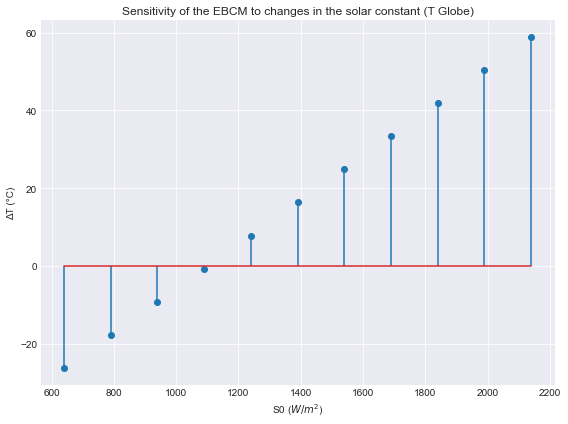

In [5]:
""" Sensivity of the energy-balance climate model to changes in the solar constant """

fig, ax = plt.subplots(figsize=(8, 6))
values = []
for s0 in range(min_solar, max_solar + dt_solar, dt_solar):
    t_globe, _ = EBCM(s0)
    values.append((s0, t_globe.max() - 273.15))
values = np.array(values)
ax.stem(values[:, 0], values[:, 1])
ax.set_title("Sensitivity of the EBCM to changes in the solar constant (T Globe)")
ax.set_xlabel("S0 ($W/m^{2}$)")
ax.set_ylabel("ΔT (°C)")
ax.grid()
plt.tight_layout()
plt.show()

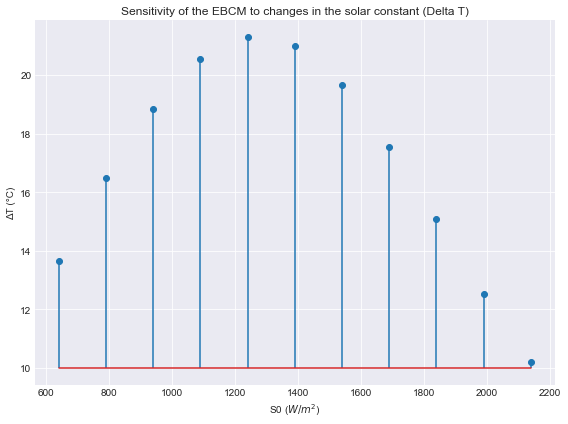

In [6]:
""" Sensitivity of the tropical-extratropical temperature contrast 
in the energy-balance climate model to changes in the solar constant """

fig, ax = plt.subplots(figsize=(8, 6))
values = []
for s0 in range(min_solar, max_solar + dt_solar, dt_solar):
    _, delta_t = EBCM(s0)
    values.append((s0, delta_t.max()))
values = np.array(values)
ax.stem(values[:, 0], values[:, 1], bottom = 10)
ax.set_title("Sensitivity of the EBCM to changes in the solar constant (Delta T)")
ax.set_xlabel("S0 ($W/m^{2}$)")
ax.set_ylabel("ΔT (°C)")
ax.grid()
plt.tight_layout()
plt.show()